In [234]:
import pandas as pd
import numpy as np
from sklearn import model_selection
import xgboost
import warnings

warnings.filterwarnings("ignore")

In [681]:
df = pd.read_csv('clean_data.csv')
df.head()

,Адрес,Жилая,Кухня,Метро,Общая,Цена,Цена за квадрат,Этаж,Этажность здания,Время,Способ передвижения,Широта дома,Долгота дома,Широта метро,Долгота метро
0,"Юбилейная улица, 16, Мытищи, Московская област...",24.0,10.0,Медведково,48.0,6550000.0,136458.0,12,25,15.0,на транспорте,55.913162,37.713063,55.887473,37.661527
1,"Кутузовский проспект, 4/2, Москва, Россия",45.0,NaN,Киевская,64.0,26000000.0,406250.0,4,7,13.0,пешком,55.750727,37.562272,55.743588,37.565587
2,"1-й Колобовский переулок, 13/14с3, Москва, Россия",23.4,8.9,Трубная,40.0,18000000.0,450000.0,2,3,5.0,пешком,55.769216,37.617411,55.767939,37.621884
3,"Мосфильмовская улица, 8, Москва, Россия",63.0,20.0,Парк Победы,98.0,59900000.0,611224.0,33,54,11.0,на транспорте,55.723257,37.527660,55.736934,37.516009
4,"Комсомольский проспект, 42с2, Москва, Россия",48.0,NaN,Спортивная,67.3,37900000.0,563150.0,4,5,10.0,пешком,55.721731,37.572899,55.723247,37.564105


In [682]:
df= df.drop(columns='Адрес', axis=1)

In [683]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Способ передвижения'] = le.fit_transform(df['Способ передвижения'])

In [684]:
df.head()

,Жилая,Кухня,Метро,Общая,Цена,Цена за квадрат,Этаж,Этажность здания,Время,Способ передвижения,Широта дома,Долгота дома,Широта метро,Долгота метро
0,24.0,10.0,Медведково,48.0,6550000.0,136458.0,12,25,15.0,0,55.913162,37.713063,55.887473,37.661527
1,45.0,NaN,Киевская,64.0,26000000.0,406250.0,4,7,13.0,1,55.750727,37.562272,55.743588,37.565587
2,23.4,8.9,Трубная,40.0,18000000.0,450000.0,2,3,5.0,1,55.769216,37.617411,55.767939,37.621884
3,63.0,20.0,Парк Победы,98.0,59900000.0,611224.0,33,54,11.0,0,55.723257,37.527660,55.736934,37.516009
4,48.0,NaN,Спортивная,67.3,37900000.0,563150.0,4,5,10.0,1,55.721731,37.572899,55.723247,37.564105


## Добавим расстояние от дома до центра города

In [685]:
from geopy import distance

lon_center, lat_center = 55.753595, 37.621031

In [686]:
df['До центра'] = df[['Широта дома', 'Долгота дома']].apply(
    lambda x: distance.distance((x[0],x[1]),(lon_center, lat_center)).km, axis = 1
)

In [687]:
df['До метро'] = df[['Широта дома', 'Долгота дома', 'Широта метро', 'Долгота метро']].apply(
    lambda x: distance.distance((x[0],x[1]),(x[2],x[3])).km, axis = 1
)

In [688]:
df.head()

,Жилая,Кухня,Метро,Общая,Цена,Цена за квадрат,Этаж,Этажность здания,Время,Способ передвижения,Широта дома,Долгота дома,Широта метро,Долгота метро,До центра,До метро
0,24.0,10.0,Медведково,48.0,6550000.0,136458.0,12,25,15.0,0,55.913162,37.713063,55.887473,37.661527,18.678507,4.309681
1,45.0,NaN,Киевская,64.0,26000000.0,406250.0,4,7,13.0,1,55.750727,37.562272,55.743588,37.565587,3.703355,0.821647
2,23.4,8.9,Трубная,40.0,18000000.0,450000.0,2,3,5.0,1,55.769216,37.617411,55.767939,37.621884,1.753987,0.314697
3,63.0,20.0,Парк Победы,98.0,59900000.0,611224.0,33,54,11.0,0,55.723257,37.527660,55.736934,37.516009,6.768081,1.689556
4,48.0,NaN,Спортивная,67.3,37900000.0,563150.0,4,5,10.0,1,55.721731,37.572899,55.723247,37.564105,4.661193,0.577809


In [689]:
df = df[df['До центра'] < 35]
df.shape

(5394, 16)

In [690]:
import math

In [691]:
def azimute(long, lat):
    #pi - число pi, rad - радиус сферы (Земли)
    rad = 6372795
 
    #координаты двух точек
    llat1 = lat
    llong1 = long

    llat2 = lat_center
    llong2 = lon_center

    #в радианах
    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.

    #косинусы и синусы широт и разницы долгот
    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    #вычисления длины большого круга
    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)
    dist = ad*rad

    #вычисление начального азимута
    x = (cl1*sl2) - (sl1*cl2*cdelta)
    y = sdelta*cl2
    z = math.degrees(math.atan(-y/x))

    if (x < 0):
        z = z+180.

    z2 = (z+180.) % 360. - 180.
    z2 = - math.radians(z2)
    anglerad2 = z2 - ((2*math.pi)*math.floor((z2/(2*math.pi))) )
    angledeg = (anglerad2*180.)/math.pi
    
    return round(angledeg, 3)

In [692]:
df['Азимут'] = df[['Широта дома', 'Долгота дома']].apply(
    lambda x: azimute(x[0],x[1]), axis = 1
)

In [693]:
df.head()

,Жилая,Кухня,Метро,Общая,Цена,Цена за квадрат,Этаж,Этажность здания,Время,Способ передвижения,Широта дома,Долгота дома,Широта метро,Долгота метро,До центра,До метро,Азимут
0,24.0,10.0,Медведково,48.0,6550000.0,136458.0,12,25,15.0,0,55.913162,37.713063,55.887473,37.661527,18.678507,4.309681,233.971
1,45.0,NaN,Киевская,64.0,26000000.0,406250.0,4,7,13.0,1,55.750727,37.562272,55.743588,37.565587,3.703355,0.821647,2.214
2,23.4,8.9,Трубная,40.0,18000000.0,450000.0,2,3,5.0,1,55.769216,37.617411,55.767939,37.621884,1.753987,0.314697,286.313
3,63.0,20.0,Парк Победы,98.0,59900000.0,611224.0,33,54,11.0,0,55.723257,37.527660,55.736934,37.516009,6.768081,1.689556,14.432
4,48.0,NaN,Спортивная,67.3,37900000.0,563150.0,4,5,10.0,1,55.721731,37.572899,55.723247,37.564105,4.661193,0.577809,27.669


In [860]:
drop_columns = ['Цена', 'Цена за квадрат', 'Метро','Широта метро','Долгота метро']

In [861]:
X = df.drop(columns=drop_columns, axis=1)
y = df['Цена за квадрат']

In [862]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [863]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [864]:
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [865]:
from sklearn import linear_model

In [866]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [867]:
from sklearn import metrics

In [868]:
metrics.mean_absolute_error(y_train, lr.predict(X_train))

79437.40867216667

In [869]:
metrics.mean_absolute_error(y_test, lr.predict(X_test))

82544.12398833613

In [870]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [871]:
X_train_norm = scale.transform(X_train)
X_test_norm = scale.transform(X_test)

In [872]:
scale_target = preprocessing.StandardScaler()
scale_target.fit(y_train.values.reshape(-1, 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [873]:
y_train_norm = scale_target.transform(y_train.values.reshape(-1, 1))
y_test_norm = scale_target.transform(y_test.values.reshape(-1, 1))

In [874]:
lr1 = linear_model.LinearRegression()
lr1.fit(X_train_norm, y_train_norm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [875]:
metrics.mean_squared_error(y_test_norm, lr1.predict(X_test_norm))

0.6431376408064482

In [876]:
lr_r = linear_model.Ridge(alpha=10.0)
lr_r.fit(X_train_norm, y_train_norm)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [877]:
metrics.mean_squared_error(y_train_norm, lr_r.predict(X_train_norm))

0.43751521360453216

In [878]:
metrics.mean_squared_error(y_test_norm, lr_r.predict(X_test_norm))

0.6402071687222767

In [879]:
params = {
    "n_estimators": 1000,
    "max_depth": 10,
    "min_samples_split": 2,
    "learning_rate": 0.01,
}
xgb = xgboost.XGBRegressor(**params, silent=True)
xgb.fit(X_train_norm, y_train_norm)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, min_samples_split=2, missing=nan,
       monotone_constraints=None, n_estimators=1000, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
       subsample=1, tree_method=None, validate_parameters=False,
       verbosity=None)

In [880]:
metrics.mean_squared_error(y_train_norm, xgb.predict(X_train_norm))

0.0016785288540150435

In [881]:
metrics.mean_squared_error(y_test_norm, xgb.predict(X_test_norm))

0.1476782346709542

In [882]:
xgb.feature_importances_

array([0.0039315 , 0.01038496, 0.05590103, 0.01005211, 0.04373822,
       0.00799125, 0.02907779, 0.0333174 , 0.04958156, 0.6289351 ,
       0.01882952, 0.10825954], dtype=float32)

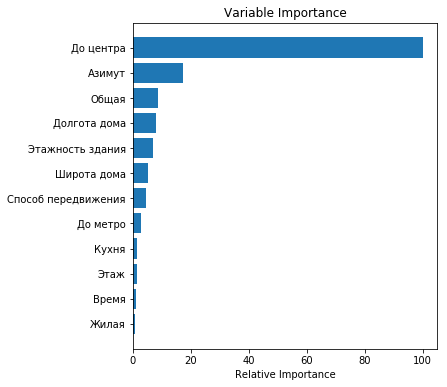

In [883]:
plt.figure(figsize=(12, 6))
# Plot feature importance
feature_importance = xgb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [884]:
np.random.seed(42)

mse_sample = []
for n_estimators in range(300, 1000, 100):
    for max_depth in range(2, 10, 1):
        for min_samples_split in range(2, 4, 1):
            xgb1 = xgboost.XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
            )
            xgb1.fit(X_train_norm, y_train_norm)
            xgb1_predict = xgb1.predict(X_test_norm)
            mse_sample.append(
                [
                    n_estimators,
                    max_depth,
                    min_samples_split,
                    np.sum((y_test_norm - xgb1_predict) ** 2),
                ]
            )

In [889]:
sorted(mse_sample, key=lambda x: x[3])[0]

[300, 2, 2, 5904302.820635517]

In [886]:
params = {
    "n_estimators": 300,
    "max_depth": 2,
    "min_samples_split": 2,
    "learning_rate": 0.01,
}
xgb1 = xgboost.XGBRegressor(**params, silent=True)
xgb1.fit(X_train_norm, y_train_norm)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.01, max_delta_step=0, max_depth=2,
       min_child_weight=1, min_samples_split=2, missing=nan,
       monotone_constraints=None, n_estimators=300, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
       subsample=1, tree_method=None, validate_parameters=False,
       verbosity=None)

In [887]:
metrics.mean_squared_error(y_train_norm, xgb1.predict(X_train_norm))

0.2530968563681427

In [888]:
metrics.mean_squared_error(y_test_norm, xgb1.predict(X_test_norm))

0.24566852877738818